In [1]:
import networkx as nx
import pandas as pd
import random as rand
import numpy as np
import matplotlib.pyplot as plt
import celluloid as cld
from collections import Counter
from tqdm.notebook import tqdm

In [2]:
class Agent():
    """
    Initializes an agent with 
    opinion        1, 2, or 3
    status         "S", "I", "uI", "R" or "aR"
    share          True or False
    frequency      (int)
    resistance     True or False
    dark           True or False
    
    that can believe and/or share their opinion
    and can output their network information
    """
    
    def __init__(self, opinion=0, status="S", shares=.5, frequency=1, resistance=False, dark=False):
        """
        [default]
        opinion: (int)
            [0]: no opinion
            1: disinformation
            2: fact checking
        status: (str)
            ["S"]: susceptible
            "I": infected
            "R": resistant
        share: (bool)
            [True]: can share their opinion
            False: can't share their opinion
        frequency: (int)
            [1]: how often the opinion is shared per share call
        resistance: (bool)
            True: can't change their opinion
            [False]: can change their opinion
        dark: (bool)
            True: is a 'dark agent' that can trigger disinfo campaigns
            [False]: not a dark agent
        """
        self.opinion=opinion
        self.status=status
        self.shares=shares
        self.frequency=frequency
        self.resistance=resistance
        
        self.dark=dark
        self.active_attack = False
        self.pause = False
        self.attack_frequency = 50
        
        self.prop_1 = .5
        self.prop_2 = 1
        self.prop_vax = 0
        
        self.friends=[]
        self.node_id=None
        
        self.opinion_history = []
        self.engagement = []
        self.next_opinion = False
        
    def share(self):
        self.engagement = []
        
        if rand.random() <= self.shares:
            #if self.status == "S":
            if self.opinion == 0:
                self.engagement = [0 for s in range(self.frequency)]
            #elif self.status == "R":
                #self.engagement = [0 for s in range(self.frequency)]
            #elif self.status == "aR":
            elif self.opinion == 2:
                self.engagement = [2 for s in range(self.frequency)]
            #elif self.status == "I":
            elif self.opinion == 1:
                self.engagement = [1 for s in range(self.frequency)]
            #elif self.status == "uI":
                #self.engagement = [1 for s in range(self.frequency)]
            else:
                raise ValueError
            #print('self.engagement is', self.engagement)
            
    def check_friends(self):
        if self.resistance == False:
            all_opinions = []
            for friend in self.friends:
                #print(f'friend {friend.node_id}s engagement is {friend.engagement}')
                all_opinions.extend(friend.engagement)

            count = Counter(all_opinions)
            
            #print('counter is', count)
            if self.resistance != True:
                n_1 = count.get(1)
                if n_1:
                    prop = n_1/len(all_opinions)
                    #print('prob is', prop)
                    if prop > self.prop_1:
                        self.next_opinion = 1
                        self.status = "I"
                        self.resistance = True
                    else:
                        self.next_opinion = self.opinion
                else:
                    self.next_opinion = self.opinion
            else:
                self.next_opinion = self.opinion
                
            n_2 = count.get(2)
            if n_2:
                if self.resistance != True:
                    if rand.random() < self.prop_2:
                        self.resistance = True
                        self.status = "R"
                        self.next_opinion = 0
                        if rand.random() < self.prop_vax:
                            self.next_opinion = 2
                            self.status = 'aR'
                    else:
                        self.next_opinion = self.opinion
                
        else:
            self.next_opinion = self.opinion
                
    def update_opinion(self): # maybe not necessary, looking at engagement, not opinion of friends
        self.opinion_history.append(self.opinion)
        self.opinion = self.next_opinion
        
    def node_output(self):
        return (
            self.node_id,
            dict(
                opinion=self.opinion,
                status=self.status,
                share=self.share,
                resistance=self.resistance,
                dark=self.dark,
            )          
        )
    
    def tie_output(self):
        tie_list = []
        for friend in self.friends:
            tie_list.append((
                self.node_id,
                friend.node_id
            ))
            
        return tie_list
    
    def attack(self, tick, kind=0, start=5, attack_length=5, decay=10):
        if self.dark == True:
            
            if kind == 0:
                if tick == start:
                    self.frequency = self.attack_frequency
                    self.share()
                    self.frequency = 1
                else:
                    self.share()
            
            elif kind == 1:
                if tick == start:
                    self.active_attack = attack_length - 1
                    freq = self.attack_frequency
                    for a in range(self.active_attack):
                        if freq > 0:
                            freq -= decay
                    self.attack_frequency = freq
                    self.frequency = self.attack_frequency
                    self.share()
                    self.frequency = 1
                    self.pause = True
                
                else:
                    if self.active_attack:
                        if self.pause:
                            self.share()
                            self.pause = False
                        else:
                            self.attack_frequency += decay
                            self.frequency = self.attack_frequency
                            self.share()
                            self.frequency = 1
                            self.pause = True
                            self.active_attack -= 1
                            if self.active_attack < 1:
                                self.active_attack = False
                    else:
                        self.share()
            
            elif kind == 2:
                if tick == start:
                    self.active_attack = attack_length - 1
                    self.frequency = self.attack_frequency
                    self.share()
                    self.frequency = 1
                    self.pause = True
                
                else:
                    if self.active_attack:
                        if self.pause:
                            self.frequency = self.attack_frequency
                            self.share()
                            self.frequency = 1
                            self.pause = False
                        else:
                            if self.attack_frequency > 0:
                                self.attack_frequency -= decay

                            self.frequency = self.attack_frequency
                            self.share()
                            self.frequency = 1
                            self.pause = True
                            self.active_attack -= 1
                            if self.active_attack < 1:
                                self.active_attack = False
                    else:
                        self.share()
                
            
            else:
                self.share()

                            
            
            
            #self.is_attack = True
            #self.attack_start = start
    
    def alter_agent(self, kind='dark', attack_strength=50):
        """
        changes the agent to one of the following states:
        
        'dark'
        'light'
        """
        
        if kind == 'dark':
            self.opinion=1
            self.status='uI'
            self.shares=1
            self.frequency=1
            self.resistance=True
            self.dark=True
            self.attack_frequency = attack_strength
            
        elif kind == 'light':
            self.opinion=2
            self.status='aR'
            self.shares=1
            self.frequency=1
            self.resistance=True
            self.dark=False

In [3]:
def run_model(
    popsize = 100,
    n_ticks = 20,
    n_friends = 5,
    n_add = 5,
    shareprob=.5,
    
    attack_start = 5,
    attack_kind = 0,
    atk_len = 5,
    atk_str = 50,
    decay=10,
    dark_quantile = .75,
    
    prebunk_prob = 1,
    vaxprob = 0,
    
    nodemult=50,
    
    draw = True,
    verbose = True,
):
    if verbose:
        print('initiallizing population')        
        
    population = []
    chosen = []
    for i in range(popsize):
        agent = Agent()
        agent.node_id = i
        agent.shares=shareprob
        agent.prop_2 = prebunk_prob
        agent.prop_vax = vaxprob
        population.append(agent)
        chosen.append(agent)
    
    if verbose:
        print('initiallizing friends')
    for i in range(n_friends):
    #print(i)
        for agent in population:
            #print(agent)
            n_friends = i+1
            #print(len(agent.friends))
            while len(agent.friends) < n_friends:
                fr = rand.choice(chosen)
                #print(fr)
                if fr == agent:
                    continue
                elif fr in agent.friends:
                    continue
                else:
                    agent.friends.append(fr)
                    for k in range(n_add):
                        chosen.append(fr)
        
    if verbose:
        print('initiallizing light and dark')
    light = Counter(chosen).most_common(1)[0][0]

    c = Counter(chosen)
    n_list = []
    for k in c.keys():
        n_list.append(c[k])
    med_in = np.quantile(n_list, dark_quantile, interpolation='nearest')
    m_list = []
    for k in c.keys():
        if c[k] == med_in:
            m_list.append(k)

    dark = rand.choice(m_list)
    
    light.alter_agent('light')
    dark.alter_agent('dark', attack_strength=atk_str)
    
    if verbose:
        print('initial plots')
    node_list = []
    tie_list = []
    for agent in population:
        node_list.append(agent.node_output())
        tie_list.extend(agent.tie_output())
    
    if draw:
        G = nx.DiGraph()
        G.add_nodes_from(node_list)
        G.add_edges_from(tie_list)

        color_dict = {
            0:'grey',
            1:'red',
            2:'green'
        }

        status_dict = {
            "S":'grey',
            "R":'lightgreen',
            "aR":'darkgreen',
            "I":'red',
            "uI":'darkred'
        }
        
        colors = [status_dict[G.nodes[val]['status']] for val in G.nodes]
        degrees = [val*nodemult for (node, val) in G.degree()]

        lay = nx.kamada_kawai_layout(G)

        fig = plt.figure(figsize=(30, 40))

        n_s = []
        n_i = []
        n_r = []

        e_s = []
        e_i = []
        e_r = []

        ns = 0
        ni = 0
        nr = 0

        es = 0
        ei = 0
        er = 0

        net_start = fig.add_subplot(3, 2, 1)
        #plt.annotate('net', xy = (0.5, 0.5), va = 'center', ha = 'center')
        nx.draw_networkx(G, pos=lay, arrows=True, ax=net_start, node_size=degrees, node_color=colors)
    

    
    if verbose:
        print('run model')
    for tick in range(n_ticks):

        for agent in population:
            if agent.dark == True:
                agent.attack(tick=tick, kind=attack_kind, start=5, attack_length=atk_len, decay=decay)
            else:
                agent.share()

        for agent in population:
            agent.check_friends()

        for agent in population:
            agent.update_opinion()

        ### vvv this is all for plotting purposes vvv ###
        if draw:
            ns = 0
            ni = 0
            nr = 0

            es = 0
            ei = 0
            er = 0

            for agent in population:
                if agent.opinion == 0:
                    ns+=1
                    es+=len(agent.engagement)
                    agent.engagement = []
                elif agent.opinion == 1:
                    ni+=1
                    ei+=len(agent.engagement)
                    agent.engagement = []
                elif agent.opinion == 2:
                    nr+=1
                    er+=len(agent.engagement)
                    agent.engagement = []

            n_s.append(ns)
            n_i.append(ni)
            n_r.append(nr)

            e_s.append(es)
            e_i.append(ei)
            e_r.append(er)

    if draw:    
        node_list = []
        tie_list = []
        for agent in population:
            node_list.append(agent.node_output())
            tie_list.extend(agent.tie_output())

        G = nx.DiGraph()
        G.add_nodes_from(node_list)
        G.add_edges_from(tie_list)

        status_dict = {
            "S":'grey',
            "R":'lightgreen',
            "aR":'darkgreen',
            "I":'red',
            "uI":'darkred'
        }

        colors = [color_dict[G.nodes[val]['opinion']] for val in G.nodes]
        colors = [status_dict[G.nodes[val]['status']] for val in G.nodes]
        degrees = [val*nodemult for (node, val) in G.degree()]

        net_end = fig.add_subplot(3, 2, 2)
        #plt.annotate('net2', xy = (0.5, 0.5), va = 'center', ha = 'center')
        nx.draw_networkx(G, pos=lay, arrows=True, ax=net_end, node_size=degrees, node_color=colors)

        nagents = fig.add_subplot(3, 2, (3,4))
        #plt.annotate('nagents', xy = (0.5, 0.5), va = 'center', ha = 'center')

        volshare = fig.add_subplot(3, 2, (5,6))
        #plt.annotate('volshare', xy = (0.5, 0.5), va = 'center', ha = 'center')

        nagents.plot(n_s, color='grey')
        nagents.plot(n_i, color='red')
        nagents.plot(n_r, color='green')

        volshare.plot(e_s, color='grey')
        volshare.plot(e_i, color='red')
        volshare.plot(e_r, color='green')
    
        
    count_s = 0
    count_i = 0
    count_r = 0
    for agent in population:
        if agent.status == 'S':
            count_s += 1
        elif agent.status == 'I':
            count_i += 1
        elif agent.status == 'uI':
            count_i += 1
        elif agent.status == 'R':
            count_r += 1
        elif agent.status == 'aR':
            count_r += 1
        else:
            raise ValueError
        
    info_dict = dict(
        popsize=popsize,
        n_ticks=n_ticks,
        n_friends=n_friends,
        n_add=n_add,

        attack_start=attack_start,
        attack_kind=attack_kind,
        dark_quantile=dark_quantile,

        prebunk_prob=prebunk_prob,
        vax_prob = vaxprob,

        n_s = count_s,
        n_i = count_i,
        n_r = count_r
    )

    return info_dict
    ### ^^^ this is all for plotting purposes ^^^ ###

{'popsize': 100,
 'n_ticks': 100,
 'n_friends': 5,
 'n_add': 5,
 'attack_start': 5,
 'attack_kind': 0,
 'dark_quantile': 0.75,
 'prebunk_prob': 0.3,
 'vax_prob': 0.1,
 'n_s': 25,
 'n_i': 7,
 'n_r': 68}

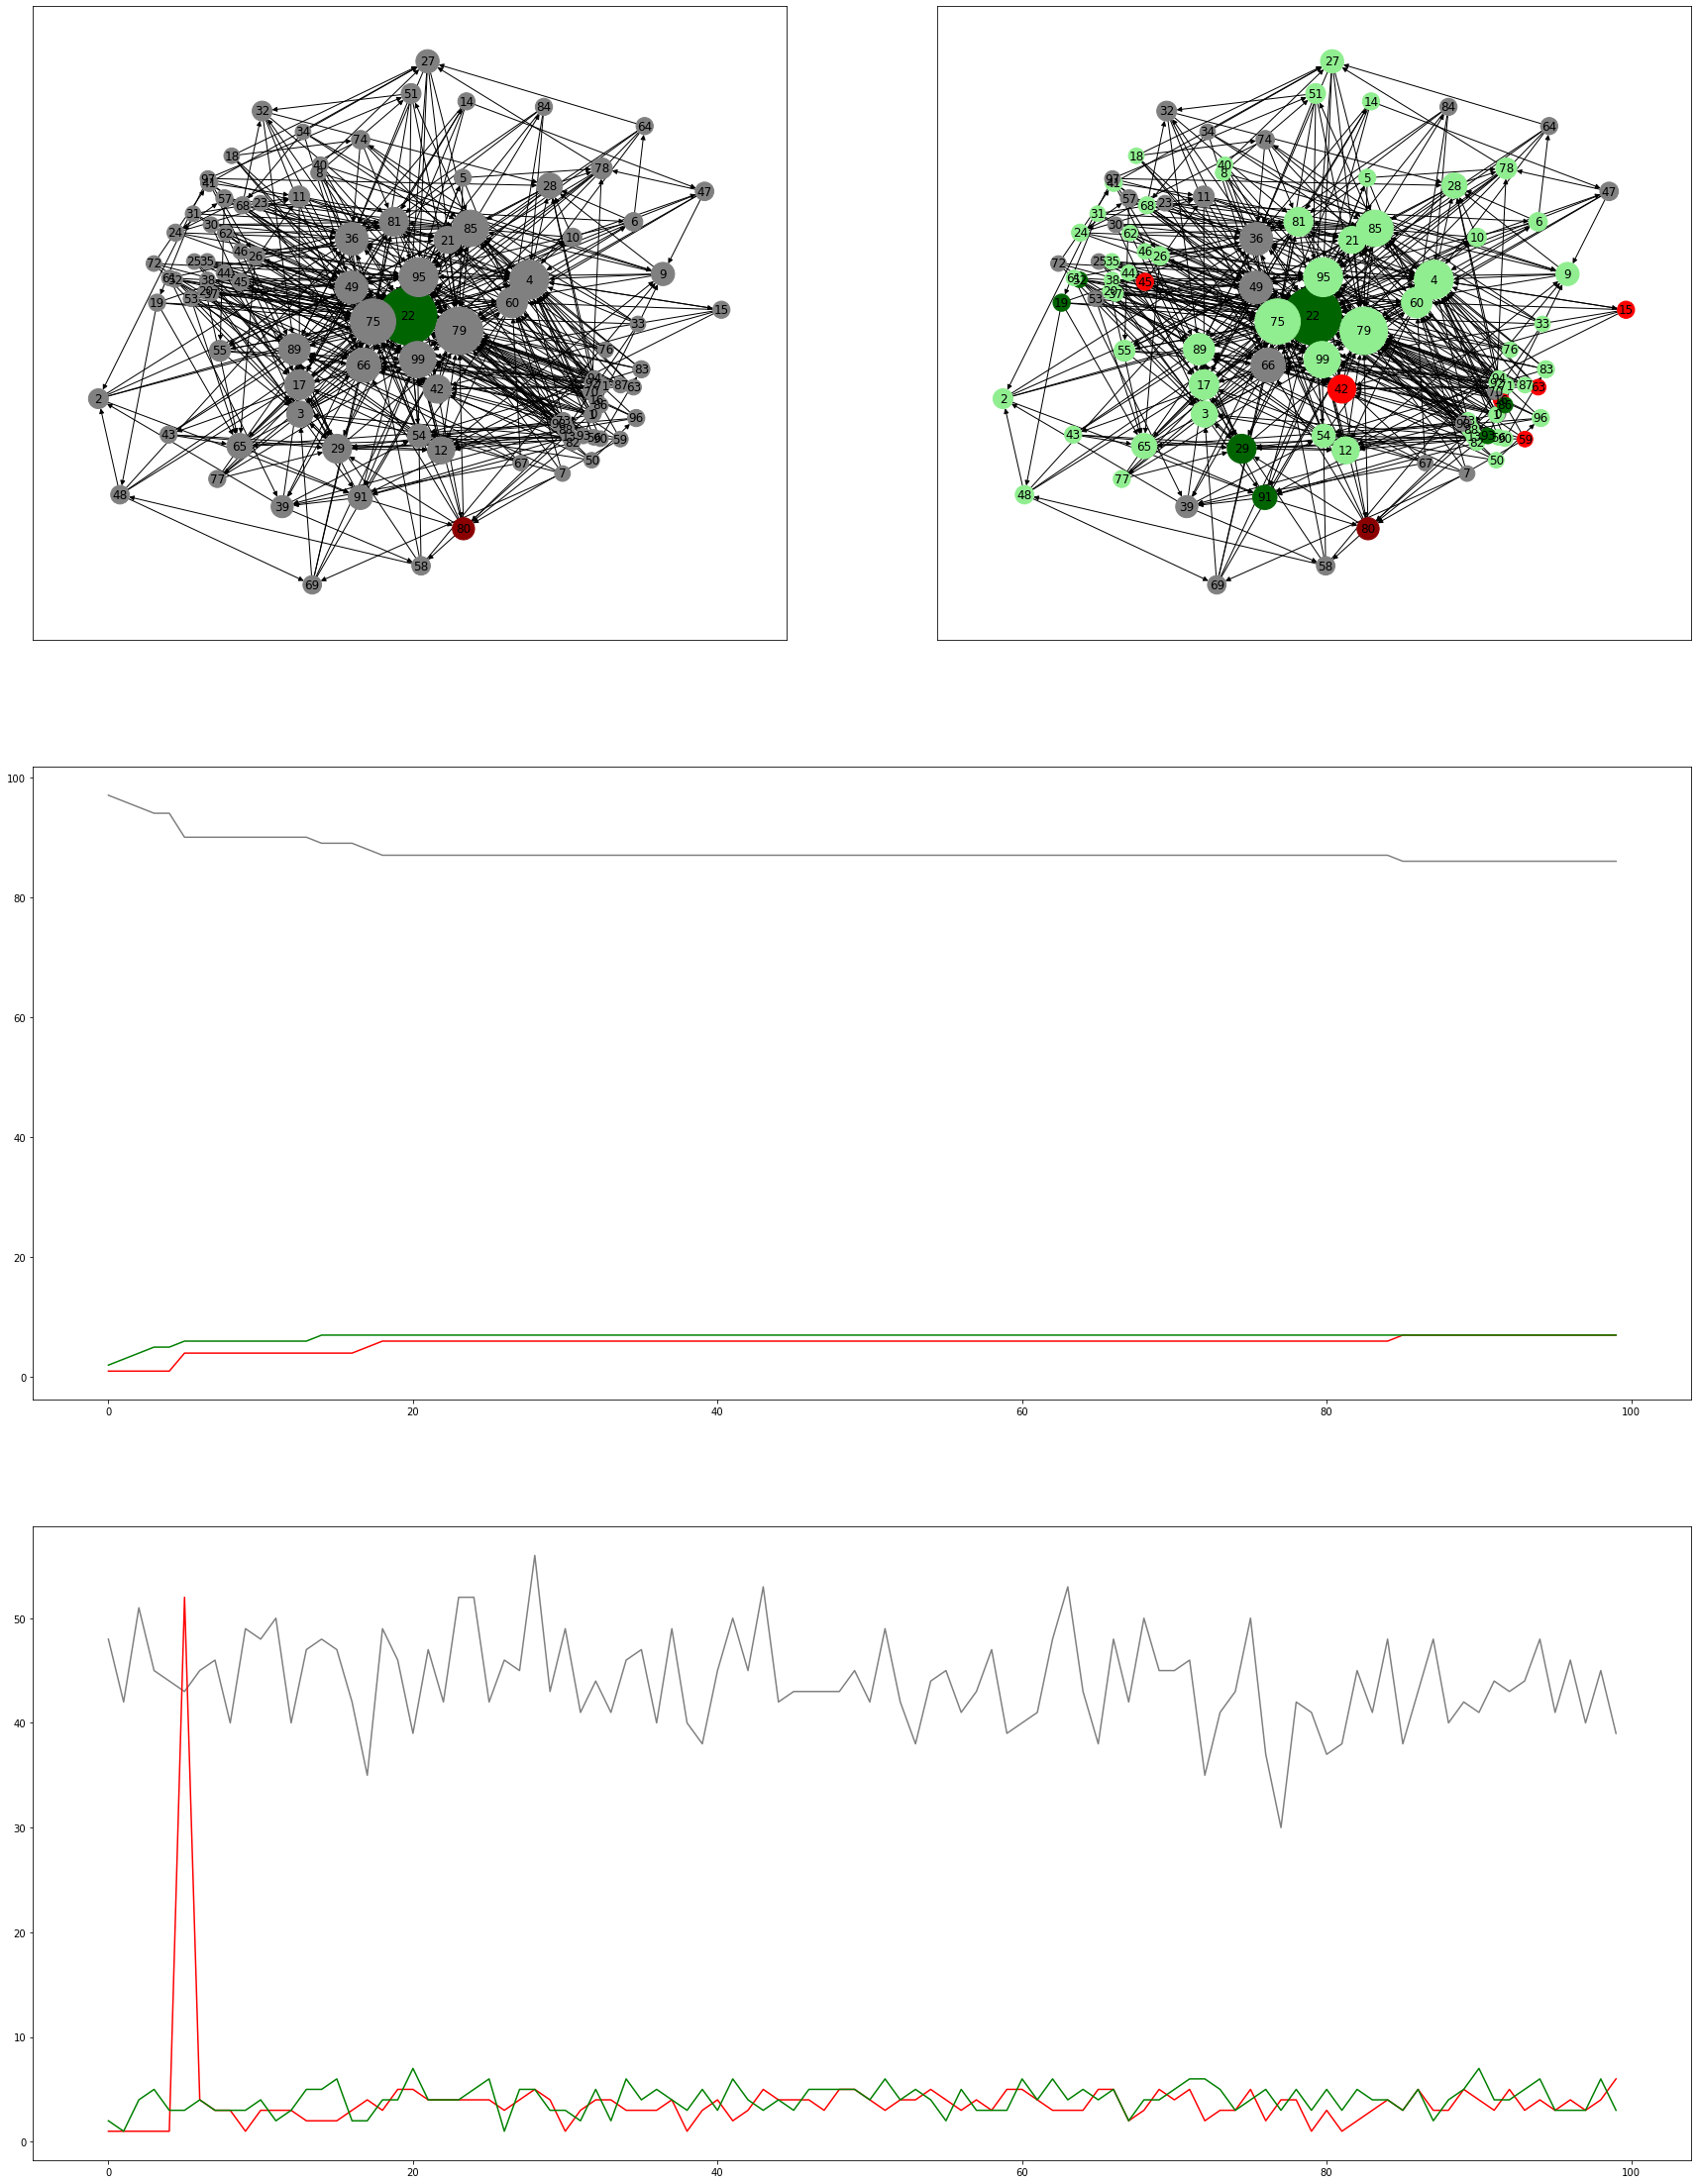

In [4]:
run_model(
    popsize = 100,
    n_ticks = 100,
    n_friends = 5,
    n_add = 5,
    shareprob = .5,

    attack_start = 5,
    attack_kind = 0,
    atk_len=10,
    atk_str=50,
    decay=5,
    dark_quantile = .75,

    prebunk_prob = .3,
    vaxprob=.1,
    #draw = False,
    verbose=False
)

In [71]:
np.round(.5, 1)

0.5

In [84]:
.1 *10

1.0

In [90]:
fig = plt.figure(figsize=(14, 28))

<Figure size 1008x2016 with 0 Axes>

In [96]:
for i in np.arange(0, .2, .1):
    print(i, np.round(i, 1))

0.0 0.0
0.1 0.1


In [ ]:
    popsize = 100,
    n_ticks = 20,
    n_friends = 5,
    n_add = 5,
    shareprob=.5,
    
    attack_start = 5,
    attack_kind = 0,
    dark_quantile = .85,
    
    prebunk_prob = 1,
    vaxprob = 0,
    
    nodemult=50,
    
    draw = True,
    verbose = True,

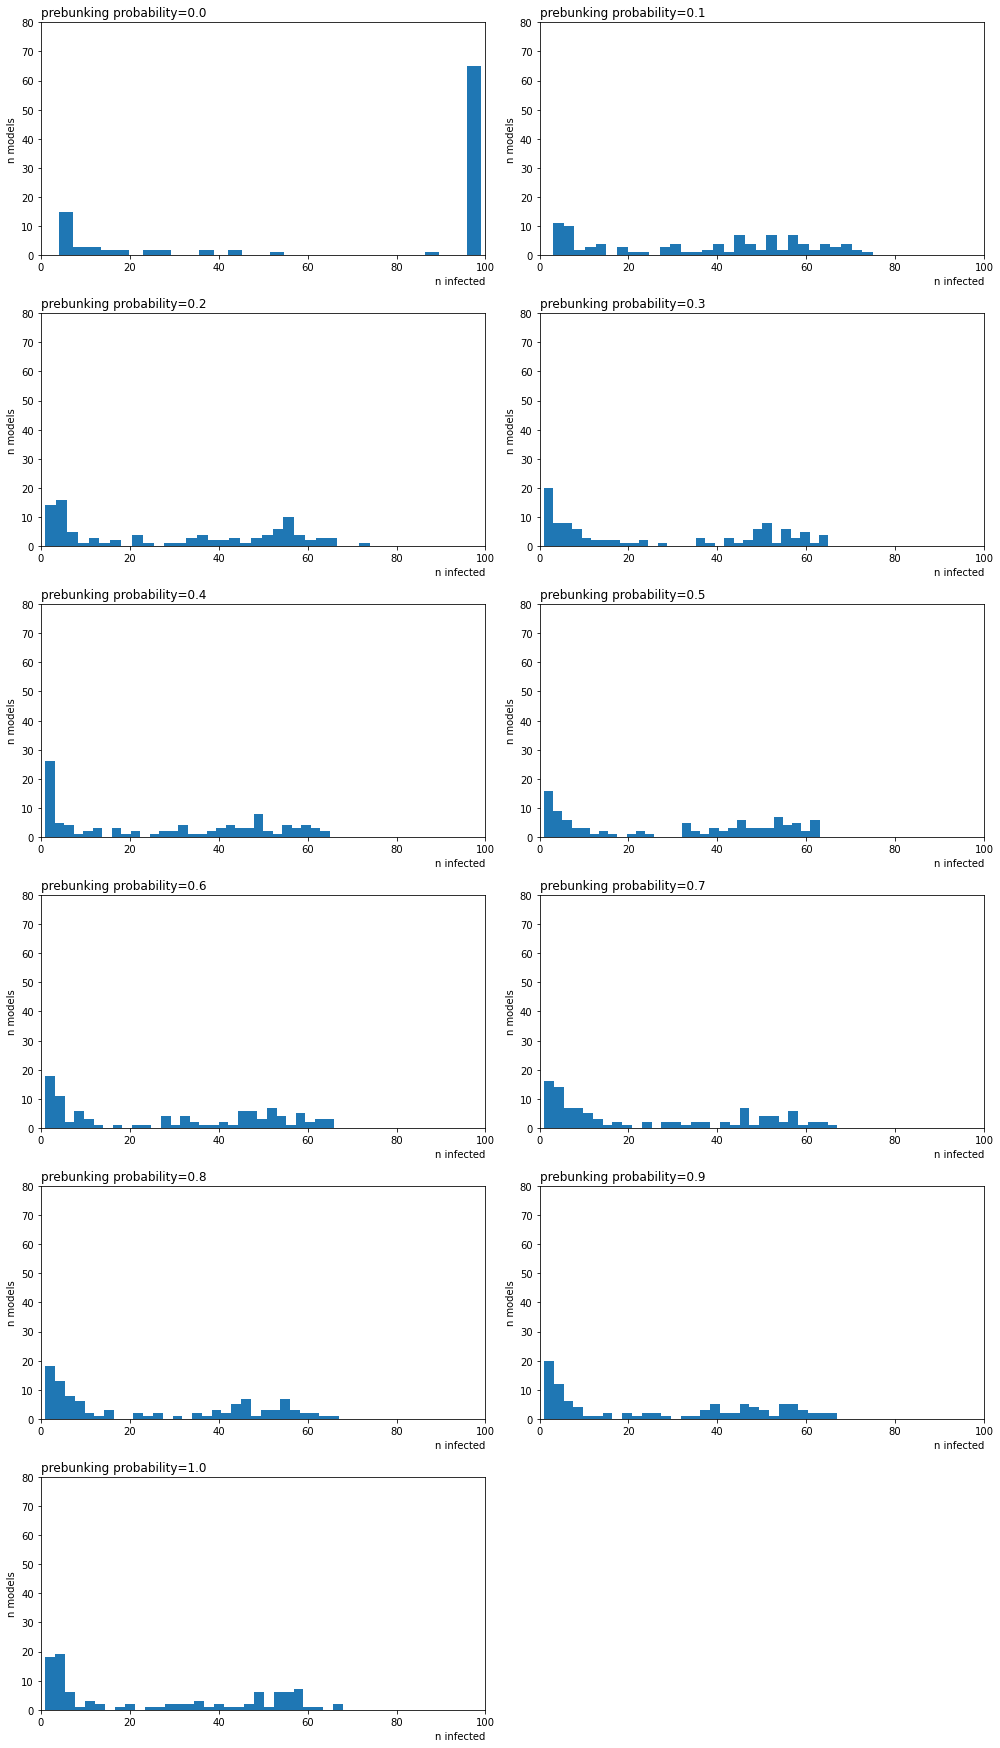

In [212]:
fig = plt.figure(figsize=(14, 28))

for prob in np.arange(0, 1.1, .1):
    prob = np.round(prob, 1)
    s_list = []
    i_list = []
    r_list = []
    
    for l in range(100):

        ret_dict = run_model(

            popsize = 100,
            n_ticks = 100,
            n_friends = 5,
            n_add = 5,
            shareprob = .5,

            attack_start = 5,
            attack_kind = 2,
            atk_len=5,
            atk_str=50,
            decay=10,
            dark_quantile = .75,

            prebunk_prob = .5,
            vaxprob=.1,
            draw = False,
            verbose=False
        )

        s_list.append(ret_dict.get('n_s'))
        i_list.append(ret_dict.get('n_i'))
        r_list.append(ret_dict.get('n_r'))
    
    
    position = int(prob*10) + 1 
    newplot = fig.add_subplot(7,2, position)
    newplot.hist(i_list, density=False, bins=30)
    newplot.set_title(f'prebunking probability={prob}', loc='left')
    newplot.set_xlabel('n infected', loc='right')
    newplot.set_ylabel('n models')
    newplot.set_xlim(0,100)
    newplot.set_ylim(0,80)
    

fig.tight_layout()

In [5]:
prebunking_probabilities = [np.round(i, 1) for i in np.arange(0, 1.1, .1)]
vaccination_probabilities = [np.round(i, 1) for i in np.arange(0, 1.1, .1)]

In [ ]:
for p in prebunking_probabilities:
    s_list = []
    i_list = []
    r_list = []
    for l in range(100):            
        add_dict = run_model(
            popsize = 100,
            n_ticks = 100,
            n_friends = 5,
            n_add = 5,
            shareprob = .5,

            attack_start = 5,
            attack_kind = a,
            dark_quantile = .75,

            prebunk_prob = p,
            vaxprob=v,

            draw = False,
            verbose=False
        )
        s_list.append(ret_dict.get('n_s'))
        i_list.append(ret_dict.get('n_i'))
        r_list.append(ret_dict.get('n_r'))


In [6]:
gather_df = pd.DataFrame()
for p in tqdm(prebunking_probabilities):
    for v in tqdm(prebunking_probabilities):
        for a in tqdm(range(0,3)):
            
            if a == 2:
                alen = 5
            else:
                alen = 3

            s_list = []
            i_list = []
            r_list = []
            for l in range(100):            
                add_dict = run_model(
                    popsize = 100,
                    n_ticks = 100,
                    n_friends = 5,
                    n_add = 5,
                    shareprob = .5,

                    attack_start = 5,
                    attack_kind = a,
                    atk_len=alen,
                    atk_str=50,
                    decay=10,
                    dark_quantile = .75,

                    prebunk_prob = p,
                    vaxprob=v,
                    draw = False,
                    verbose=False
                )
                s_list.append(add_dict.get('n_s'))
                i_list.append(add_dict.get('n_i'))
                r_list.append(add_dict.get('n_r'))

            add_df = pd.DataFrame(dict(
                prebunking_prob = p,
                vaccination_prob = v,
                attack_kind = a,
                mean_susceptible = np.mean(s_list),
                mean_infected = np.mean(i_list),
                mean_resistant = np.mean(r_list)

            ), index=[0])
            gather_df = pd.concat([gather_df, add_df])

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
import altair as alt

In [56]:
only_pre = gather_df[(gather_df.attack_kind==0)&(gather_df.vaccination_prob==0)]

In [57]:
only_pre

,prebunking_prob,vaccination_prob,attack_kind,mean_susceptible,mean_infected,mean_resistant,mean_infected_prop
0,0.0,0.0,0,28.26,70.74,1.00,0.7074
0,0.1,0.0,0,14.09,37.49,48.42,0.3749
0,0.2,0.0,0,18.73,31.44,49.83,0.3144
0,0.3,0.0,0,24.52,24.43,51.05,0.2443
0,0.4,0.0,0,19.77,29.17,51.06,0.2917
0,0.5,0.0,0,22.72,26.33,50.95,0.2633
0,0.6,0.0,0,22.60,26.04,51.36,0.2604
0,0.7,0.0,0,21.89,26.73,51.38,0.2673
0,0.8,0.0,0,21.21,27.14,51.65,0.2714
0,0.9,0.0,0,19.33,29.46,51.21,0.2946


In [55]:
gather_df['mean_infected_prop'] = gather_df['mean_infected'] / 100

In [70]:
a = alt.Chart(gather_df[gather_df.attack_kind==0], title = 'Attack Type I').mark_line().encode(
    x=alt.X('prebunking_prob', title='P(r)'),
    y=alt.Y('mean_infected', title='mean infected (%)', scale=alt.Scale(domain=[0, 90])),
    color=alt.Color('vaccination_prob', title='P(v)'),
)

b = alt.Chart(gather_df[gather_df.attack_kind==1], title = 'Attack Type II').mark_line().encode(
    x=alt.X('prebunking_prob', title='P(r)'),
    y=alt.Y('mean_infected', title='mean infected (%)', scale=alt.Scale(domain=[0, 90])),
    color=alt.Color('vaccination_prob', title='P(v)'),
)

c = alt.Chart(gather_df[gather_df.attack_kind==2], title = 'Attack Type III').mark_line().encode(
    x=alt.X('prebunking_prob', title='P(r)'),
    y=alt.Y('mean_infected', title='mean infected (%)', scale=alt.Scale(domain=[0, 90])),
    color=alt.Color('vaccination_prob', title='P(v)'),
)

In [71]:
(a | b | c)

alt.HConcatChart(...)

In [72]:
(a & b & c)

alt.VConcatChart(...)

In [73]:
a

alt.Chart(...)

In [74]:
b

alt.Chart(...)

In [75]:
c

alt.Chart(...)

In [ ]:
len(gather_df)

  0%|          | 0/6 [00:00<?, ?it/s]

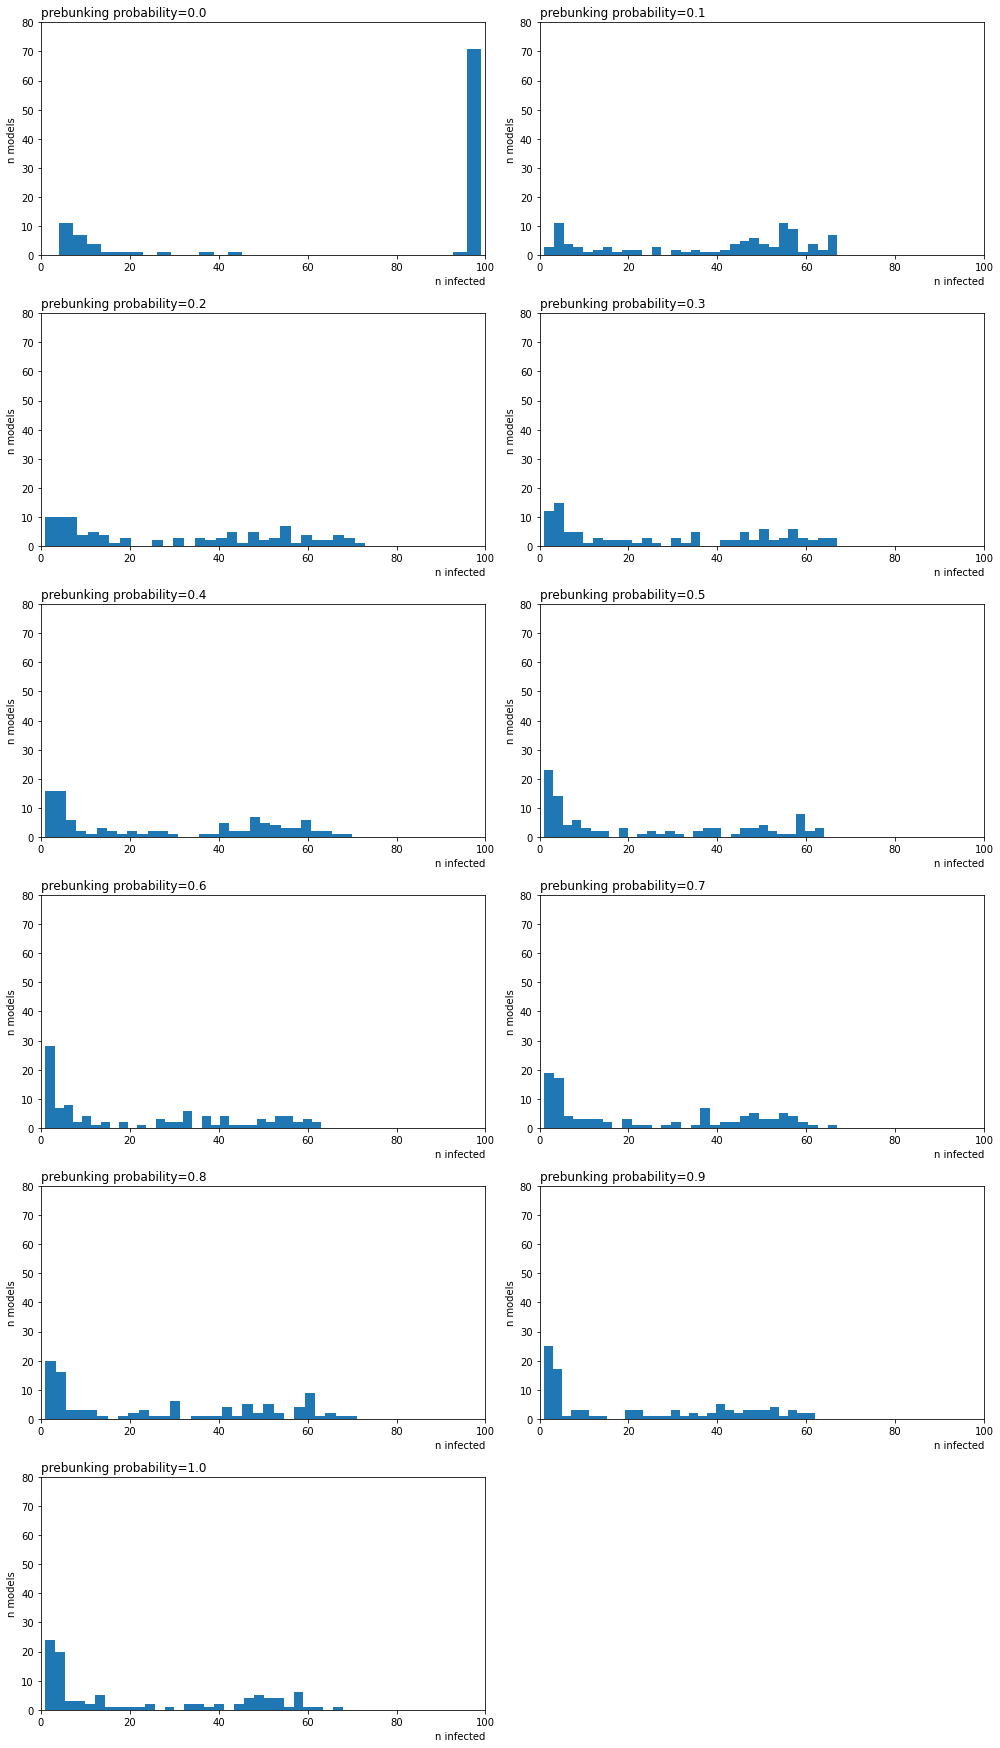

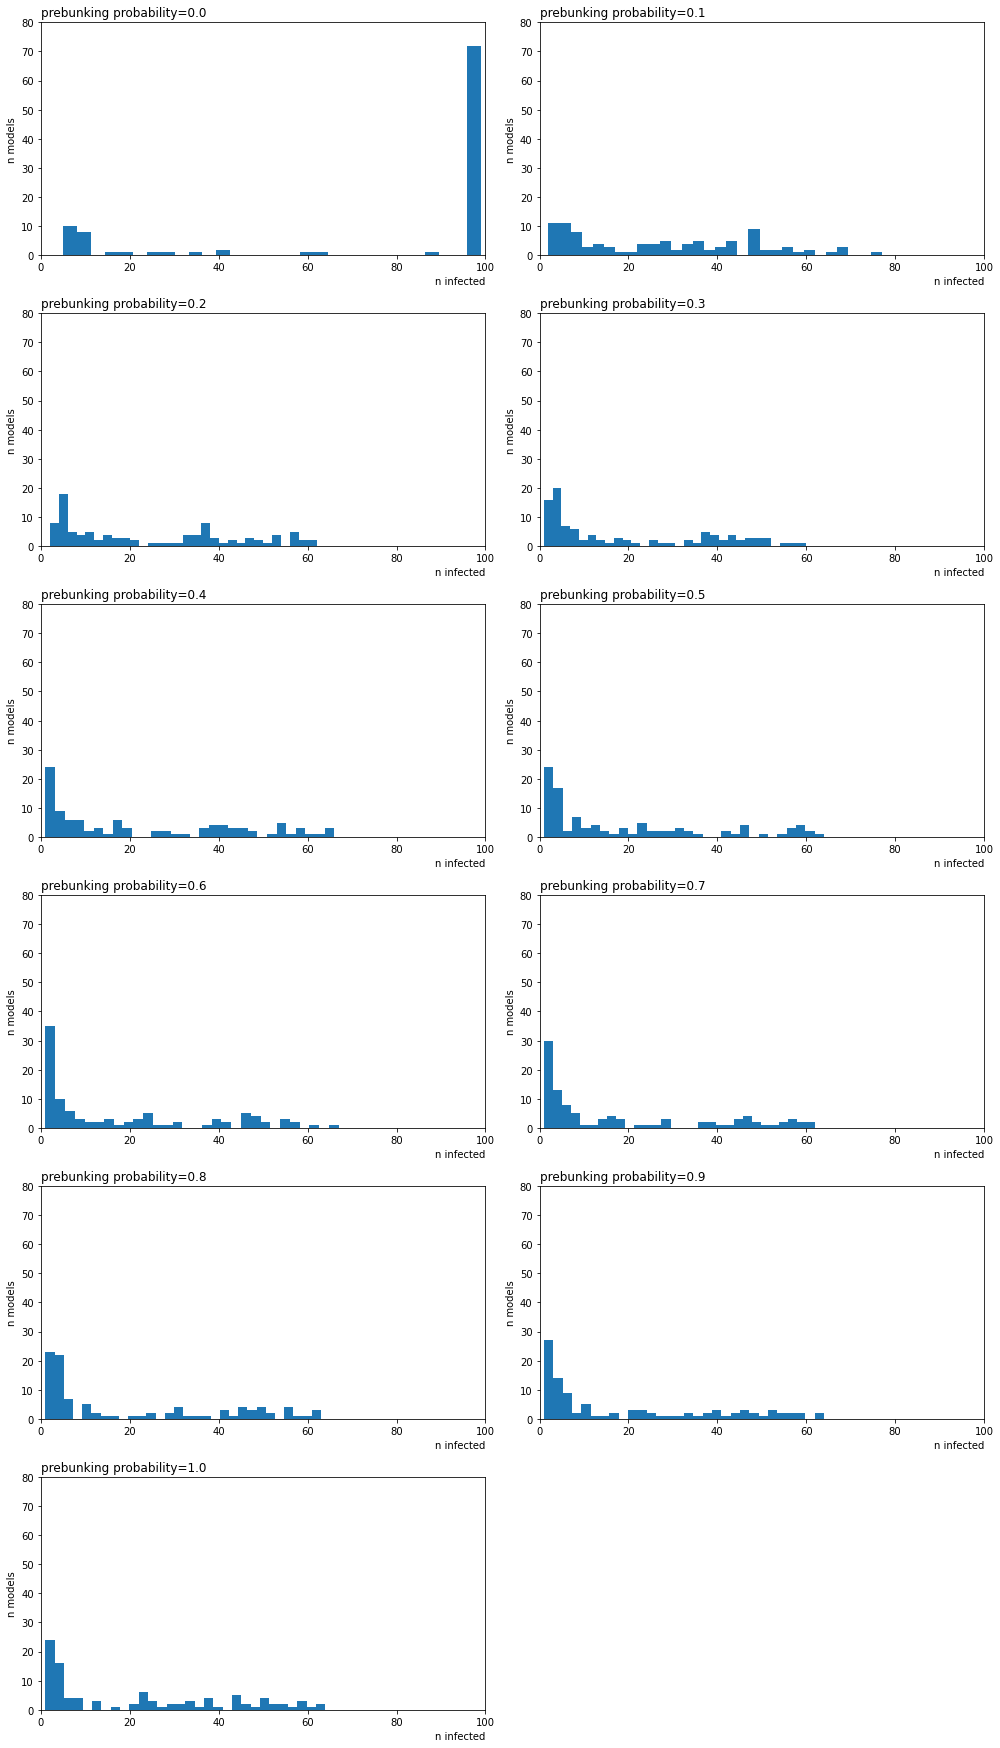

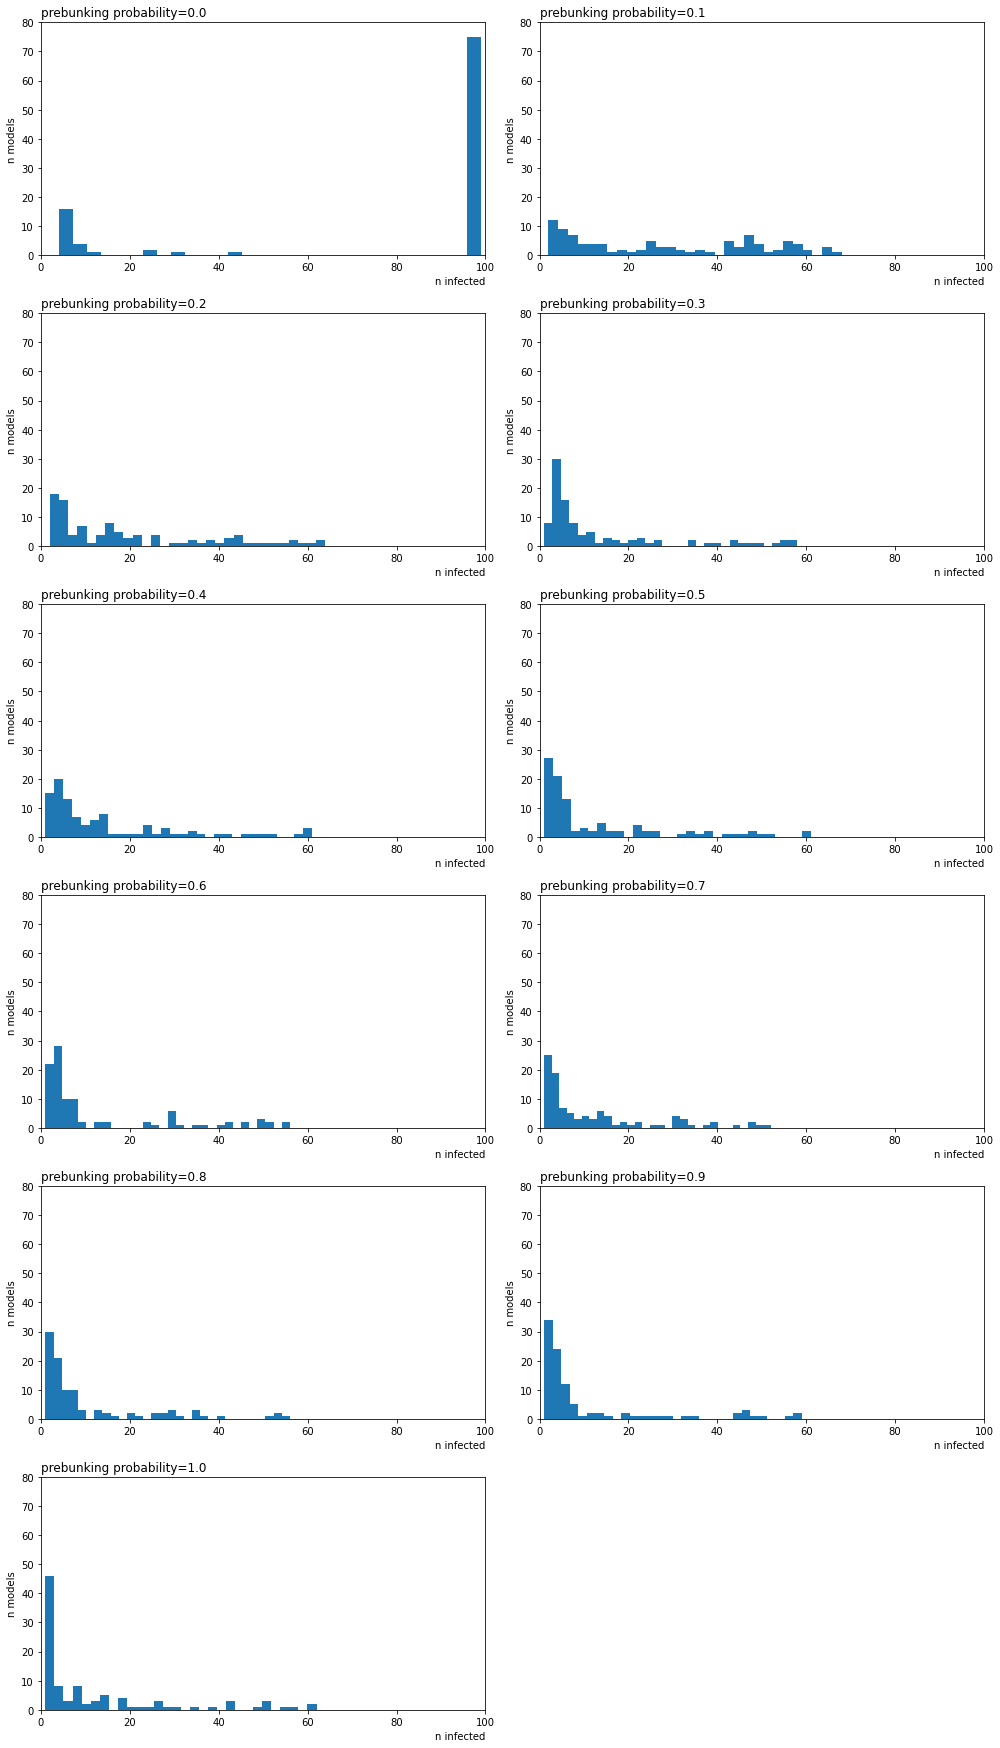

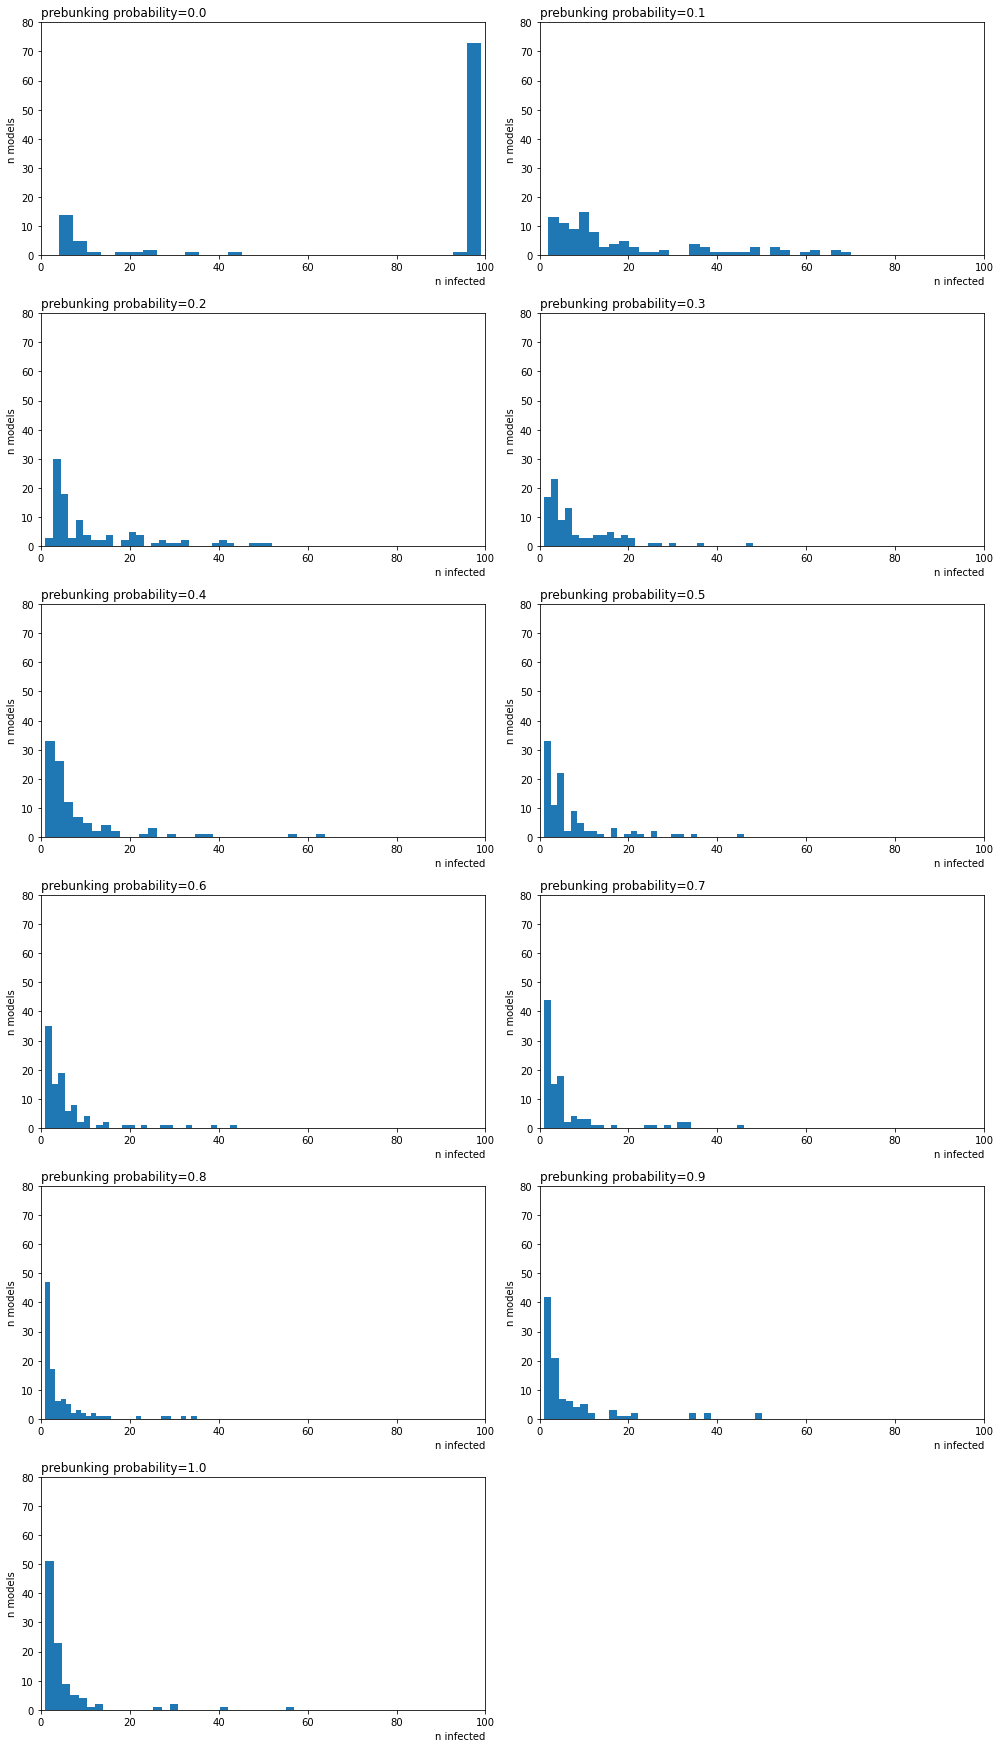

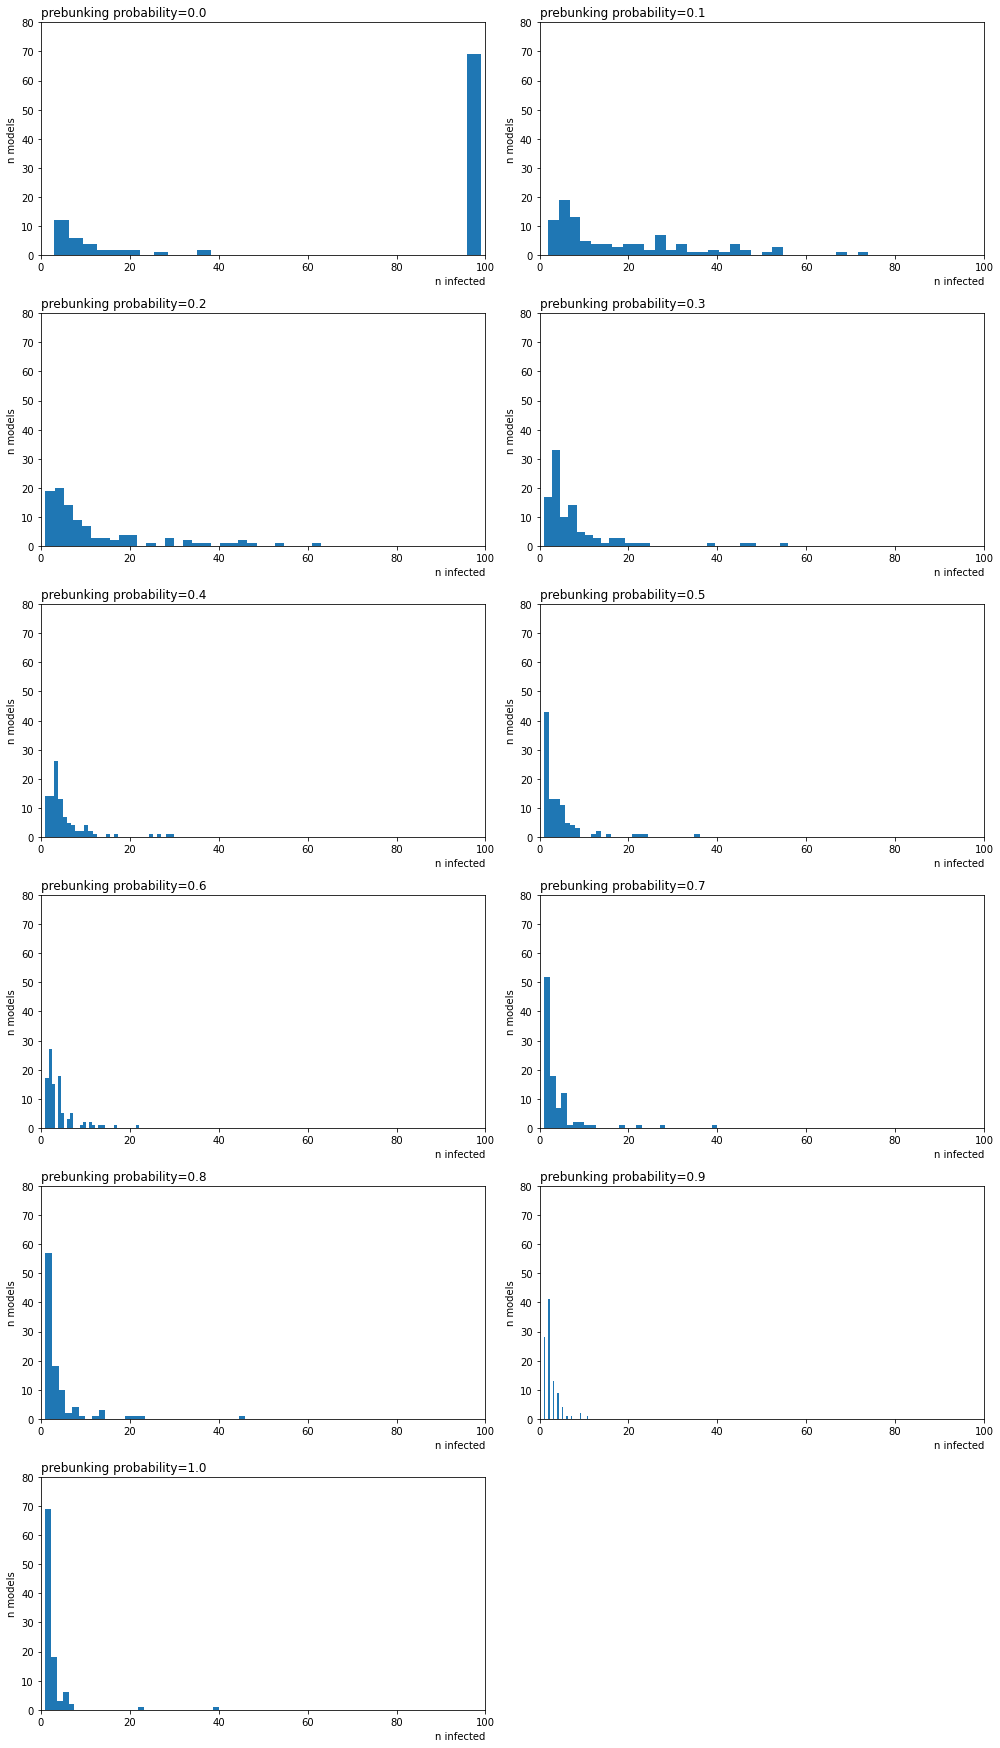

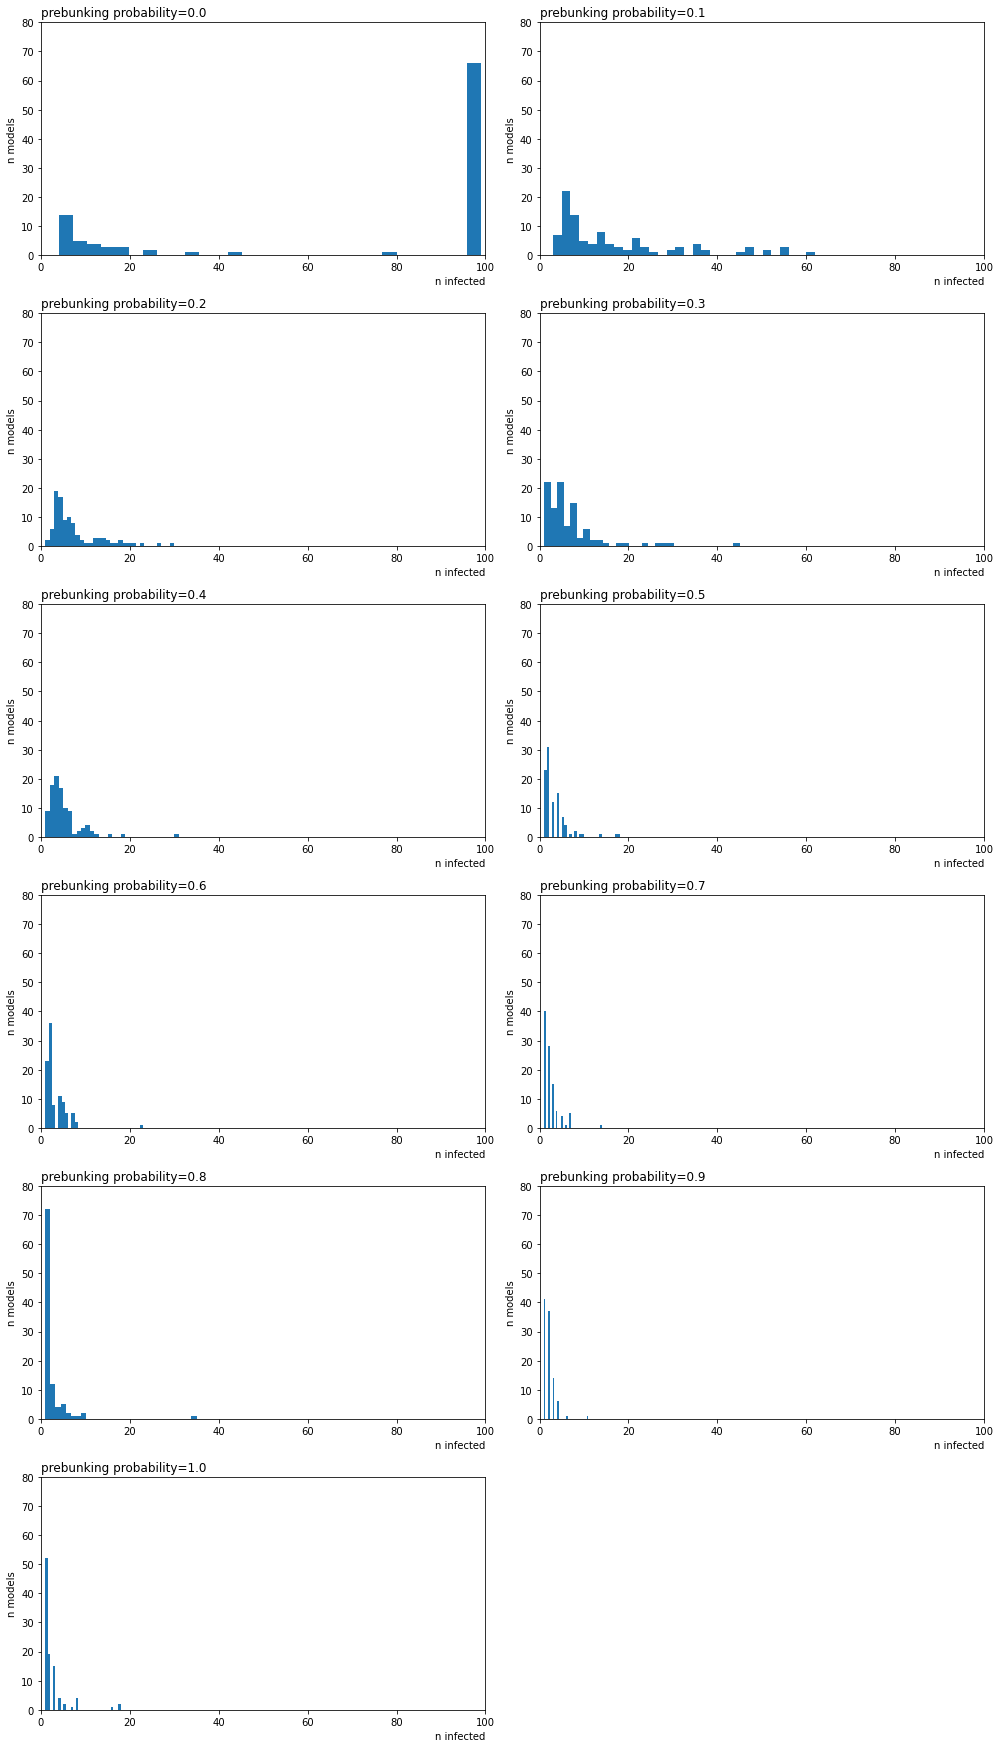

In [216]:
for v in tqdm(np.arange(0, .6, .1)):
    fig = plt.figure(figsize=(14, 28))
    for prob in np.arange(0, 1.1, .1):
        prob = np.round(prob, 1)
        s_list = []
        i_list = []
        r_list = []
        
        for l in range(100):
            ret_dict=run_model(
                    popsize = 100,
                    n_ticks = 100,
                    n_friends = 5,
                    n_add = 5,
                    shareprob = .5,

                    attack_start = 5,
                    attack_kind = 0,
                    dark_quantile = .75,

                    prebunk_prob = prob,
                    vaxprob=v,
                    
                    draw = False,
                    verbose=False
                )

            s_list.append(ret_dict.get('n_s'))
            i_list.append(ret_dict.get('n_i'))
            r_list.append(ret_dict.get('n_r'))
            
        position = int(prob*10) + 1 
        newplot = fig.add_subplot(7,2, position)
        newplot.hist(i_list, density=False, bins=30)
        newplot.set_title(f'prebunking probability={prob}', loc='left')
        newplot.set_xlabel('n infected', loc='right')
        newplot.set_ylabel('n models')
        newplot.set_xlim(0,100)
        newplot.set_ylim(0,80)
    

    fig.tight_layout()
    plt.savefig(f'compare_deprob_vax_{v}.pdf')

  0%|          | 0/1000 [00:00<?, ?it/s]

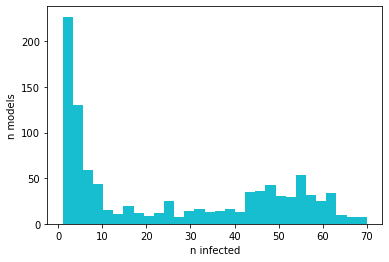

In [182]:
s_list = []
i_list = []
r_list = []
for i in tqdm(range(1000)):
    ret_dict = run_model(
        popsize = 100,
        n_ticks = 100,
        n_friends = 5,
        n_add = 5,
        shareprob=.5,

        attack_start = 5,
        attack_kind = 0,
        dark_quantile = .75,

        prebunk_prob = 1,
        draw=False,
        verbose=False
    )
    s_list.append(ret_dict.get('n_s'))
    i_list.append(ret_dict.get('n_i'))
    r_list.append(ret_dict.get('n_r'))
    
    
    plt.hist(i_list, density=False, bins=30)
    plt.ylabel('n models')
    plt.xlabel('n infected')

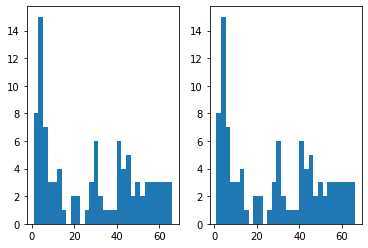

In [143]:
fig = plt.figure(1)
for p in range(1,3):
    

    ax = fig.add_subplot(1,2,p)
    ax.hist(i_list, density=False, bins=30)
    ax.set_xlim()

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([63.5       , 63.53333333, 63.56666667, 63.6       , 63.63333333,
        63.66666667, 63.7       , 63.73333333, 63.76666667, 63.8       ,
        63.83333333, 63.86666667, 63.9       , 63.93333333, 63.96666667,
        64.        , 64.03333333, 64.06666667, 64.1       , 64.13333333,
        64.16666667, 64.2       , 64.23333333, 64.26666667, 64.3       ,
        64.33333333, 64.36666667, 64.4       , 64.43333333, 64.46666667,
        64.5       ]),
 <BarContainer object of 30 artists>)

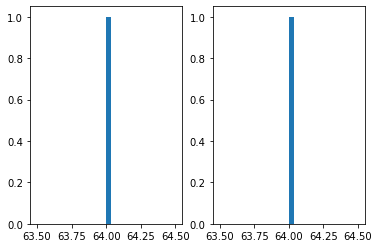

In [109]:
ax = fig.add_subplot(1,2,2)
ax.hist(i_list, density=False, bins=30)

Text(0.5, 0, 'n infected')

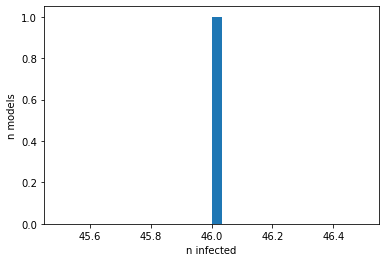

In [114]:
plt.hist(i_list, density=False, bins=30)
plt.ylabel('n models')
plt.xlabel('n infected')